In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import stpsf
import os
import sep

from astropy.io import fits
from astropy.convolution import convolve_fft
from joblib import Parallel, delayed
from astropy.stats import sigma_clipped_stats, sigma_clip
from lacosmic.core import lacosmic
from skimage.restoration import inpaint

%matplotlib widget

import warnings
warnings.filterwarnings("ignore")

import logging, sys
logging.disable(sys.maxsize)

np.set_printoptions(legacy='1.25') # my environment is a bit wonky :/

In [12]:
ref_cube = np.load('/home/phys/astronomy/jlu69/Masters/jurassic/outputs/jw01177007001_03101_00001-seg008/reference_cube.npy')
bref_cube = np.load('/home/phys/astronomy/jlu69/Masters/jurassic/outputs/jw01177007001_03101_00001-seg008/reference_cube_bool.npy')

In [10]:
len(ref_cube)

560

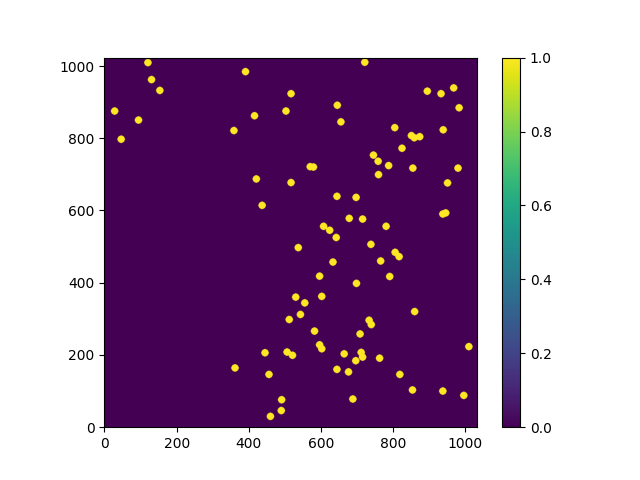

In [13]:
plt.figure()
plt.imshow(bref_cube[5],origin='lower')
plt.colorbar()
plt.show()

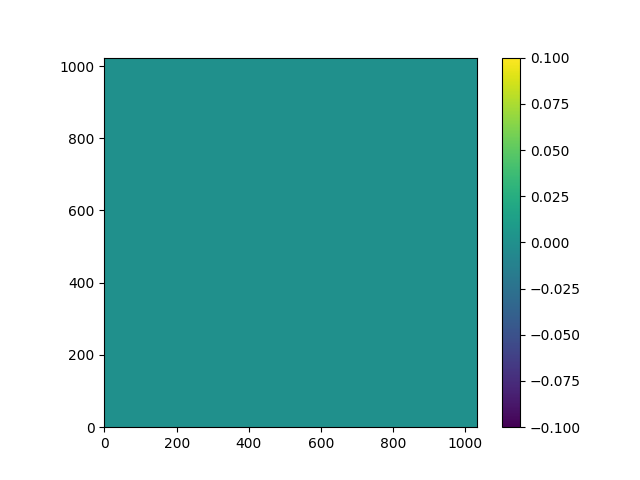

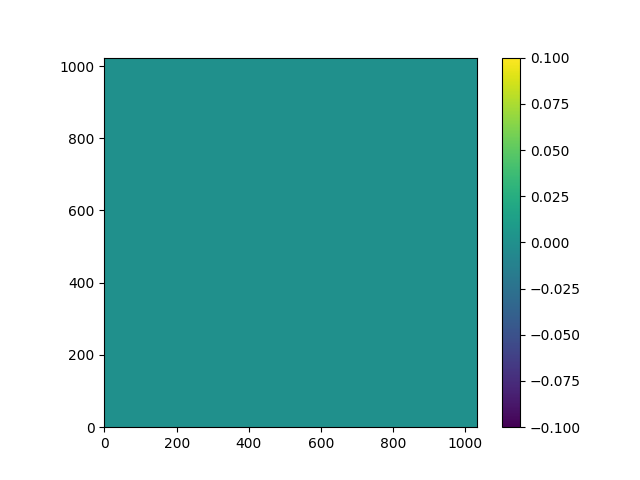

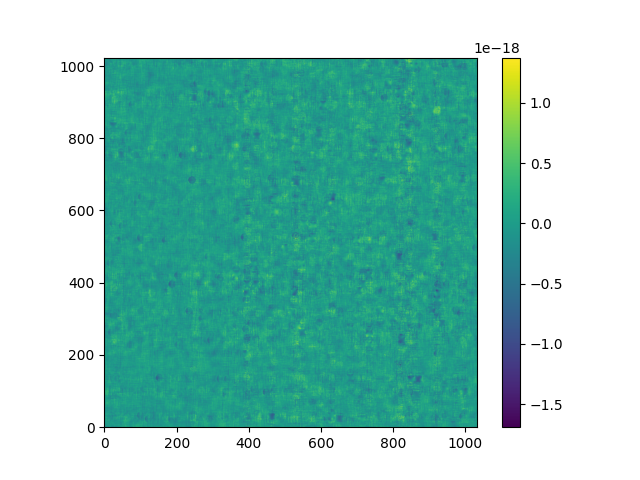

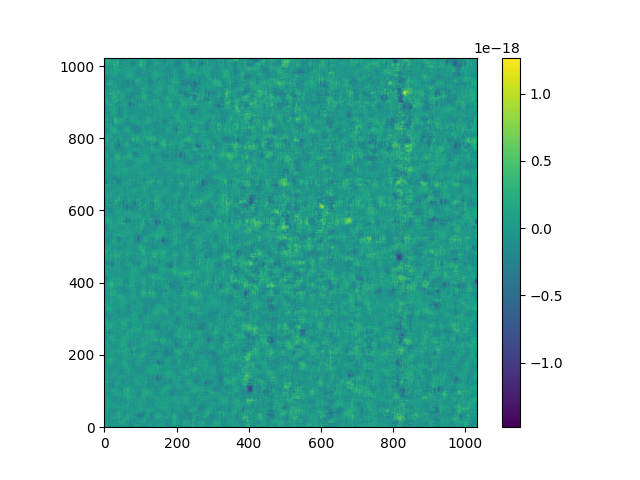

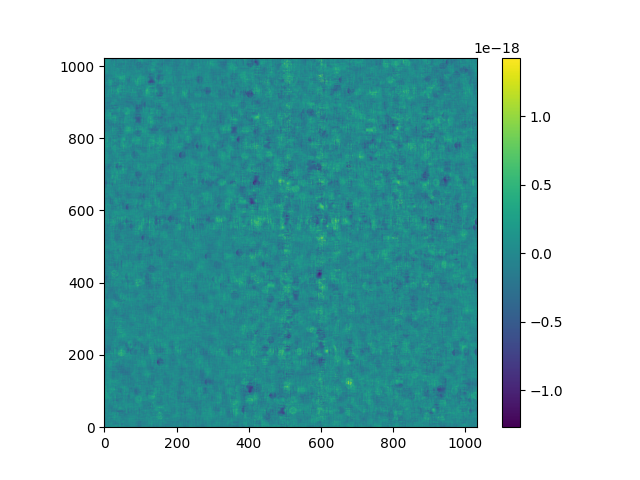

In [19]:
from skimage.restoration import inpaint

for i in range(5):#len(ref_cube)):
    image = ref_cube[i]
    mask = bref_cube[i]
    # print(image.shape)
    # print(mask.shape)
    result = inpaint.inpaint_biharmonic(image,mask)
    
    plt.figure()
    plt.imshow(result,origin='lower')
    plt.colorbar()
    plt.show()

In [2]:
def linear_fitting(coords,cube,n_int,n_group):
    """
    fits ramps piecewise with 2 straight lines if a jump is detected,
    otherwise fits a single line. If a piece is too short, fits only the longer one.
    """
    row, col = coords

    grads = [] # straight line gradient based on first data points
    intercepts = [] # straight line intercept based on first data points
    resids = [] # residuals from curve_fit of power law

    for int_num in range(n_int):
        x_dat = [i + (int_num)*n_group for i in range(n_group)]
        y_dat = [cube[x][row][col] for x in x_dat]
        x = np.asarray(x_dat, dtype=float) 
        y = np.asarray(y_dat, dtype=float)

        # removing first and last frames
        y[0] = np.nan
        y[-1] = np.nan

        mask = ~np.isnan(y)
        x = x[mask]
        y = y[mask]

        p,r,*_ = np.polyfit(x,y,1,full=True)
        m = p[0]
        c = p[1]
        grads.append(m)
        intercepts.append(c)
        resids.append(r[0] if len(r) > 0 else np.nan)
        
    return [row, col, grads, intercepts, resids]


def run_lacosmic(frame_data, mask):
    """
    running lacosmic so it can be done parallely on frames
    mask: boolean mask where True = science pixel, False = bad pixel
    """
    from astropy import log
    log.setLevel('ERROR') 
    
    masked_arr = np.where(mask, frame_data, np.nan)
    _, _, std = sigma_clipped_stats(masked_arr)
    error_arr = np.full(frame_data.shape, std)
    lacosmic_mask = ~mask # (True = masked/bad pixel)
    data_clean = np.nan_to_num(frame_data, nan=0.0, posinf=0.0, neginf=0.0) # replace nans which lacosmic doesn't like

    clean, crmask = lacosmic(data_clean,contrast=4,cr_threshold=2,
                             neighbor_threshold=0.9,mask=lacosmic_mask,error=error_arr)

    return clean, crmask

def _run_sep(frame, data, kernel, mask, save, obs_dir):
    """
    run source extractor in parallel
    """
    data = np.array(data, dtype=np.float32, copy=True)
    mask = np.array(mask, dtype=bool, copy=True)
    # get and subtract the background
    bkg = sep.Background(data, mask=~mask)
    data_sub = data - bkg

    # object detection
    objects = sep.extract(data_sub, 1.5, filter_kernel=kernel, err=bkg.globalrms, mask=~mask)
    obj_df = pd.DataFrame(objects)

    if len(obj_df) == 0:
        # return empty filtered_df with same cols
        filtered_df = pd.DataFrame(columns=obj_df.columns.tolist() + ['symmetry', 'frame', 'sep_flux', 'sep_fluxerr','sep_s/n', 'sep_flag'])
        return obj_df, filtered_df

    # adding needed cols
    obj_df['symmetry'] = (obj_df['a']/obj_df['b']).abs() - 1
    obj_df['frame'] = frame

    # aperture photometry
    flux, fluxerr, flag = sep.sum_circle(data_sub, obj_df['x'], obj_df['y'], 3.0, err=bkg.globalrms, gain=1.0) # ap radius = 3.0
    obj_df['sep_flux'] = flux
    obj_df['sep_fluxerr'] = fluxerr
    obj_df['sep_s/n'] = flux/fluxerr
    # flux/fluxerr for s/n
    obj_df['sep_flag'] = flag

    # apply filtering
    filter_mask = ((obj_df['symmetry'] < 0.5) & # used to be 1.5
                    obj_df['x'].between(16, 1016) &
                    obj_df['y'].between(12, 1012))
    filtered_df = obj_df[filter_mask]

    # plotting
    if save and len(filtered_df) > 0:
        from matplotlib.patches import Ellipse
        matplotlib.use("Agg") # don't show em
        fig, ax = plt.subplots()
        m, s = np.mean(data_sub*mask), np.std(data_sub*mask)
        ax.imshow(data_sub*mask, interpolation='nearest', vmin=m-s, vmax=m+s, origin='lower')
        ax.set_title(f"Frame {frame}")

        for i in filtered_df.index:
            e = Ellipse(
                xy=(filtered_df.at[i, 'x'], filtered_df.at[i, 'y']),
                width=6*filtered_df.at[i, 'a'],
                height=6*filtered_df.at[i, 'b'],
                angle=filtered_df.at[i, 'theta']*180./np.pi
            )
            e.set_facecolor('none')
            e.set_edgecolor('red')
            ax.add_artist(e)

        sep_dir = os.path.join(obs_dir, "sep_frames")
        os.makedirs(sep_dir, exist_ok=True)
        plt.savefig(os.path.join(sep_dir, f"frame_{frame:03d}.png"), bbox_inches="tight")
        plt.close(fig)

    return obj_df, filtered_df


def make_reference_cube(pixel,grad_cube):
    """
    makes a reference cube and gets a median from it
    """
    row,col = pixel
    pix = grad_cube[:,row,col]

    clipped_pix = sigma_clip(pix,sigma_upper=1,masked=False,axis=0).data

    return np.asarray(clipped_pix, dtype=float)

In [14]:
class Jurassic():
    """
        Class for searching the ramps of full array MIRI images for fast transients

        JURASSIC: JWST Up the Ramp Analysis Searching the Sky for Infrared Transients
    """

    def __init__(self,file=None,run=True,ramps=True,images=True,significance=True):
        """
        Initialise or whatevs

        Parameters
        ----------
        file : str
                File name of the observation
        

        other stuff I guess - will update at some point
        """

        self.file = file
        self.psf_fwhm_px = { # taken from JDOX
            "F560W": 1.882,
            "F770W": 2.445,
            "F1000W": 2.982,
            "F1130W": 3.409,
            "F1280W": 3.818,
            "F1500W": 4.436,
            "F1800W": 5.373,
            "F2100W": 6.127,
            "F2550W": 7.300,
        }
        
        if run:
            self._assign_data()
            self._make_cubes()
            self._mask_pixels()

            if ramps: # search on ramp level
                print('ramps')
                self.parallel_fit_df(self.rampy_cube) # only fitting rampy_cube not mega
                # self.worst_fits(self.rampy_cube) # atm has 25 worst fitting pixels
        
            if images or significance: # search on image level
                print('images')
                self.mega_inator(self.rampy_cube)
                self._cube_gradient(self.mega_cube_masked)
                self._reference_frame()
                self._cube_differenced(self.grad_cube,self.first_ref_frame,save=False)
                self._psf_kernel()
                self.source_extracting(self.diff_cube,save=False)

                print('re-difference')
                self._masked_reference() # creating new mask and doing differencing again
                self._cube_differenced(self.grad_cube,self.second_ref_frame,save=True)
                self._remove_cosmic(self.diff_cube)
                self.source_extracting(self.clean_cube,save=True)

            if significance:
                print('significance')
                self._cube_significance()
                self._cube_threshold() 
                self._cube_rolling_sum()
                self._significance_output()

            self._time_mjd()
            self.save_outputs()


    def _assign_data(self):
        """
        Opens the fits file and assigns the data to the class
        """
        with fits.open(self.file) as hdul:
            self.data = hdul[1].data # science data
            self.dq_2d_arr = hdul[2].data # data quality flag array for whole cube
            self.dq_3d_arr = hdul[3].data # data quality flag array for each group
            times = hdul[7].data
            self.time_df = pd.DataFrame(times)
            self.filter = hdul[0].header['FILTER']
            self.subarray = hdul[0].header['SUBARRAY']
            self.filename = hdul[0].header['FILENAME']
            self.targname = hdul[0].header['TARGNAME']

        # base outputs folder (cwd)
        self.base_dir = os.path.join(os.getcwd(), 'outputs')
        os.makedirs(self.base_dir, exist_ok=True)
        # Remove the filename suffix
        suffix = '_mirimage_ramp.fits'
        if self.filename.endswith(suffix):
            obs_name = self.filename[:-len(suffix)]
        else:
            obs_name = self.filename  # fallback

        obs_name = f"nb_{obs_name}" 

        # directory for specific observation/segment
        self.obs_dir = os.path.join(self.base_dir, obs_name)
        os.makedirs(self.obs_dir, exist_ok=True)

        self.n_int = len(self.data) # number of integrations (ramps) in file
        self.n_group = len(self.data[0]) # number of groups per integration
        self.n_frame = self.n_int * self.n_group # number of frames in file
        self.frames = list(range(self.n_frame)) # list of all frame indices

        bad_frames = []
        for integration in list(range(self.n_int)):
            bad_frames.append(integration*self.n_group)
            bad_frames.append(((integration+1)*self.n_group)-1)
        self.bad_frames = bad_frames

        try:
            self.fwhm = self.psf_fwhm_px[self.filter]
        except:
            print(f'Unable to find FWHM of filter {self.filter}') # need to use this to make the 


    def _make_cubes(self):
        """
        makes cube from 4d uncal file, also jump detected cube
        """
        # make the rampy science data cube
        ramps = np.array_split(self.data,self.n_int,axis=0)
        rampy_cube = np.concatenate(ramps,axis=1)
        self.rampy_cube = np.squeeze(rampy_cube)

        # make reference cube for jumps detected with calwebb_detector1
        dq_ints = np.array_split(self.dq_3d_arr,len(self.dq_3d_arr),axis=0)
        dq_cube = np.concatenate(dq_ints,axis=1)
        self.dq_cube = np.squeeze(dq_cube) # bitwise cube with all the dq flags

        flag = 4 # jump detected flag
        jump_cube = np.full(self.dq_cube.shape, False, dtype=bool)

        for frame in range(len(self.dq_cube)):
            jump_arr = (self.dq_cube[frame] & flag) == flag
            jump_cube[frame] = jump_arr

        self.jump_cube = jump_cube # a boolean cube where True is for jumps detected
        

    def _circle_app(self,rad):
        """
        Makes a kinda circular aperture, probably not worth using. - from ryan
        """
        mask = np.zeros((int(rad*2+.5)+1, int(rad*2+.5)+1))
        c = rad
        x,y = np.where(mask==0)
        dist = np.sqrt((x-c)**2 + (y-c)**2)

        ind = (dist) < rad + .2
        mask[y[ind],x[ind]] = 1

        return mask
    

    def _mask_pixels(self,threshold = 45000): # could be udated w/ quality flags from JWST
        """
        returns a list of tuples that are pixel (row,col) coordinates
        that have masked out the non-science and saturated pixels
        threshold used to be 47000 but that let things pass through that we didn't want
        """
        # load general miri mask
        mask = np.load('full_MIRI_mask.npy') # for full array

        # mask out pixels that get counts above threshold
        mask_sat = self.rampy_cube[-1] < threshold
        mask_sat = mask_sat.astype(int) # to convolve with aperture

        kernel = self._circle_app(10)

        mask_sat = convolve_fft(mask_sat, kernel)
        mask_sat = mask_sat >= 0.99 # boolean

        # creating a list of tuples which are the (row,column) coords of each science pixel
        rows = list(range(self.rampy_cube.shape[1]))
        cols = list(range(self.rampy_cube.shape[2]))

        pixels = []

        for i in rows:
            row_num = [i] * len(cols)
            pixel_row = list(zip(row_num,cols)) # tuples of a single row's (i's) pixel coordinates
            pixels.extend(pixel_row)

        if self.subarray == 'FULL':
            self.mask_tot = mask_sat & mask
        else:
            self.mask_tot = mask_sat
    
        nan_mask = self.mask_tot * 1.0 
        nan_mask[nan_mask < 1] = np.nan
        self.nan_mask = nan_mask

        pixel_mask = self.mask_tot.flatten(order='C').tolist() # flattening mask to make same size/dimensions as the list of pixel coords
        self.masked_pixels = [pixel for pixel, m in zip(pixels, pixel_mask) if m]


    def _pixel_integration(self,cube,int_num,row,col):
        """
        Gets the x and y data of a specified integration for a specific pixel in a specified cube
        """
        integration_length = list(range(0,self.n_group))
        x_dat = [i + (int_num)*self.n_group for i in integration_length]
    
        ramp = []
        for x in x_dat:
            ramp.append(cube[x][row][col])

        return x_dat, ramp   


    def parallel_fit_df(self,cube,save_df=False,num_cores=35):
        """
        fits all ramps of specified cube parallely
        """
        fitting = Parallel(n_jobs=num_cores, verbose=0)(
            delayed(linear_fitting)(pixel,cube,self.n_int,self.n_group) for pixel in self.masked_pixels)

        obj_df = pd.DataFrame(fitting, columns=["row","col","gradients","intercepts","residuals"])
        obj_df['max_residual'] = obj_df['residuals'].apply(max)

        self.obj_df = obj_df
        if save_df:
            filepath = os.path.join(self.obs_dir, 'ramp_fittings.csv')
            self.obj_df.to_csv(filepath, index=False)


    def _line(self,m,c,x):
        """
        straight line eqn
        """
        return [i*m + c for i in x]


    def _check_jump(self,coords):
        """
        checking if jump was detected in the dq cube
        """
        row, col = coords
        # check through all frames for jumps  
        vals = self.jump_cube[:, row, col]
        if vals.any():
            return 1, int(np.argmax(vals))  # 1 and first z index
        else:
            return 0, None


    def worst_fits(self, cube, num=15, require_jump=False):
        """
        Get worst fits by max_residual. Can filter based on jump status: (require_jump=True/False) or not
        """
        # add coords, jump, and jump_frame columns to obj_df
        self.obj_df['coords'] = self.obj_df.apply(lambda row: (row['row'], row['col']), axis=1)
        self.obj_df[['jump', 'jump_frame']] = self.obj_df['coords'].apply(lambda c: pd.Series(self._check_jump(c)))

        # sort by residual
        self.worst_fits_df = self.obj_df.sort_values(by='max_residual',ascending=False)

        # filter by if jump or not
        if require_jump is True:
            subdf = self.worst_fits_df[self.worst_fits_df['jump'] == 1].head(num).copy()
        elif require_jump is False:
            subdf = self.worst_fits_df[self.worst_fits_df['jump'] == 0].head(num).copy()
        else:
            subdf = self.worst_fits_df.head(num).copy()

        self.jump_fit_df = subdf

        rows = subdf['row'].values 
        cols = subdf['col'].values
        grads = subdf['gradients'].values
        cepts = subdf['intercepts'].values
        resids = subdf['residuals'].values

        plt.figure(constrained_layout=True, figsize=(16, 12))

        for i in range(len(cols)):
            ax = plt.subplot(5, 3, i + 1)
            row, col = rows[i], cols[i]

            for int_num in range(self.n_int):
                x, y = self._pixel_integration(cube, int_num, row, col)
                x, y = np.asarray(x, float), np.asarray(y, float)

                # remove first and last points
                x[[0, -1]] = np.nan
                y[[0, -1]] = np.nan

                mask = np.isfinite(y)
                x, y = x[mask], y[mask]

                # plot the data
                ax.scatter(x, y, c='tab:blue', s=5)

                # line fit
                m, c, r = grads[i][int_num], cepts[i][int_num], resids[i][int_num]
                y_line = self._line(m, c, x)
                ax.plot(x, y_line, label=f'r={r:.2f}')

            jump = subdf.iloc[i]['jump']
            jump_frame = subdf.iloc[i]['jump_frame']

            ax.set_title(f"Pixel ({row},{col}) | jump={jump}, frame={jump_frame}")
            ax.set_xlabel('Frame')
            ax.set_ylabel('Counts')
            ax.legend()

        plt.suptitle('Bad pixel ramps')
        filepath = os.path.join(self.obs_dir, 'worst_fits.png')
        plt.savefig(filepath, dpi=300)
        plt.show()


# --------------------- Image Search -----------------------


    def mega_inator(self,cube):
        """
        makes a mega cube out of a rampy one
        """
        frames = list(range(0,self.n_frame))
        integrations = list(range(0,self.n_int))
        int_frames = [i*self.n_group  for i in integrations]

        int_frames.pop(0) # in order to have list of indices of first frames in ramps except for the very first one
        end_frames = [((i+1)*self.n_group)-1 for i in integrations] # want to remove the frames with these indices

        mega_cube = np.zeros((self.n_frame,cube.shape[1],cube.shape[2]))
        difference = 0 # difference between end of one ramp and start of next
        zero_ff = 0 # fudge factor to zero the ramps

        for frame in frames:
            if frame == 0:
                zero_ff = cube[frame]
                mega_cube[frame] = cube[frame] - zero_ff
            elif frame in int_frames:
                zero_ff = cube[frame] 
                difference = mega_cube[frame-2] + 2*(mega_cube[frame-2] - mega_cube[frame-3])
                mega_cube[frame] = cube[frame] + difference - zero_ff
            else:
                mega_cube[frame] = cube[frame] + difference - zero_ff

        # recalc int_frames
        int_frames = [i * self.n_group for i in integrations]
        end_frames = [(i+1) * self.n_group -1 for i in integrations]
        int_frames.extend(end_frames)

        mega_cube_masked = mega_cube.copy()
        nans_frame = np.full_like(mega_cube_masked[0], np.nan)

        for frame in int_frames:
            mega_cube_masked[frame] = nans_frame

        self.mega_cube = mega_cube
        self.mega_cube_masked = mega_cube_masked


    def _cube_gradient(self,cube):
        """
        make a gradient cube with the fakey fake frames
        """
        fakeified_cube = cube.copy()
        for int_num in range(self.n_int-1): # for all integrations but the last one
            val = (int_num+1)*self.n_group
            fakeified_cube[val-1] = 2*fakeified_cube[val-2] - fakeified_cube[val-3] # last frame of the integration
            fakeified_cube[val] = 3*fakeified_cube[val-2] - 2*fakeified_cube[val-3] # first frame of the next integration

        self.fakey_cube = fakeified_cube

        self.grad_cube = np.gradient(fakeified_cube,axis=0)


    def _reference_frame(self):
        """
        Making a reference frame but more complicated to counteract smearing
        of bright asteroids. - Armin's suggestion (starts with original, then masks)
        """
        no_nans = np.nansum(self.grad_cube,axis=(1,2)) > 0
        no_nans[self.bad_frames] = False

        # masking out the all nan frames and the fake frames
        good_slices = self.grad_cube.copy()[no_nans]

        self.first_ref_frame = np.nanmedian(good_slices,axis=0)

        filepath = os.path.join(self.obs_dir, "first_reference_frame.npy")
        np.save(filepath, self.first_ref_frame)


    # def _reference_frame(self,num_cores=35):
    #     """
    #     Making a reference frame but more complicated to counteract smearing
    #     of bright asteroids. - ryan's suggestion
    #     """
    #     coords = self.masked_pixels 

    #     # process the pixels in parallel
    #     results = Parallel(n_jobs=num_cores, verbose=0)(
    #         delayed(make_reference_cube)(pixel, self.grad_cube) for pixel in coords)

    #     reference_cube = np.full_like(self.grad_cube, np.nan, dtype=float)

    #     for (row, col), clipped_pix in zip(coords, results):
    #         reference_cube[:, row, col] = clipped_pix

    #     reference_frame = np.nanmedian(reference_cube,axis=0)

    #     self.reference_cube = reference_cube
    #     self.med_frame = reference_frame

    #     filepath = os.path.join(self.obs_dir, "reference_frame.npy")
    #     np.save(filepath, self.med_frame)


    def _cube_differenced(self,cube,reference,save=None):
        """
        make a differenced cube from gradient cube using a median frame as reference
        """
        diff_cube = cube.copy() - reference[np.newaxis,:,:]
        diff_cube[self.bad_frames] = np.nan

        self.diff_cube = diff_cube
        self.diff_cube_masked = self.diff_cube.copy() * self.mask_tot

        if save:
            filepath = os.path.join(self.obs_dir, "diff_cube.npy")
            np.save(filepath, self.diff_cube)
        

    def _psf_kernel(self,size=10):
        """
        creates kernel based on filter using stpsf
        """
        miri = stpsf.MIRI()
        miri.filter = self.filter
        psf = miri.calc_psf(fov_pixels=size)
        self.kernel = psf[3].data

    
    # def source_extracting(self,cube,save,num_cores=35):
    #     """
    #     using source extractor (sep) instead of StarFinder
    #     """
    #     tasks = (delayed(_run_sep)(frame,cube[frame],self.kernel,self.mask_tot,save,self.obs_dir)
    #                                                 for frame in range(self.n_frame))

    #     # run in parallel
    #     results = Parallel(n_jobs=num_cores, prefer="processes")(tasks)
    #     obj_dfs, filtered_dfs = zip(*results)

    #     # combine all frames, ignore empty dfs
    #     self.total_df = pd.concat([df for df in obj_dfs if len(df) > 0], ignore_index=True)
    #     self.filtered_sep_df = pd.concat([df for df in filtered_dfs if len(df) > 0], ignore_index=True)

    #     if save:
    #         filepath = os.path.join(self.obs_dir, "filtered_sources.csv")
    #         self.filtered_sep_df.to_csv(filepath, index=False)

    #         filepath = os.path.join(self.obs_dir, "all_sources.csv")
    #         self.total_df.to_csv(filepath, index=False)


    def source_extracting(self,cube,save,num_cores=35):
        """
        using source extractor (sep) instead of StarFinder
        """
        tasks = (delayed(_run_sep)(frame,cube[frame],self.kernel,self.mask_tot,save,self.obs_dir)
                                                    for frame in range(self.n_frame))
        
        # run sep in parallel
        results = Parallel(n_jobs=num_cores, prefer="processes")(tasks)
        obj_dfs, filtered_dfs = zip(*results)

        # keep only non empty dfs
        non_empty_obj = [df for df in obj_dfs if not df.empty]
        non_empty_filt = [df for df in filtered_dfs if not df.empty]

        # total sep detections
        if len(non_empty_obj) == 0:
            self.total_df = pd.DataFrame(columns=obj_dfs[0].columns)
        else:
            self.total_df = pd.concat(non_empty_obj, ignore_index=True)

        # filtered SEP detections 
        if len(non_empty_filt) == 0:
            self.filtered_sep_df = pd.DataFrame(columns=filtered_dfs[0].columns)
        else:
            self.filtered_sep_df = pd.concat(non_empty_filt, ignore_index=True)

        # printing detection stats
        print(f"SEP: {len(non_empty_filt)} / {self.n_frame} frames with filtered detections "
              f"({len(self.filtered_sep_df)} total sources)")

        # save csv's of the filtered and unfiltered dfs
        if save:
            filepath = os.path.join(self.obs_dir, "filtered_sources.csv")
            self.filtered_sep_df.to_csv(filepath, index=False)

            filepath = os.path.join(self.obs_dir, "all_sources.csv")
            self.total_df.to_csv(filepath, index=False)

    
    # def _masked_reference(self,mask_radius=10):
    #     """
    #     Makes a reference frame (median) but masks out any variable sources
    #     Should probably infill with median of an annulus around the maksed sources
    #     but that's hard to think about rn
    #     """
    #     reference_cube = np.zeros_like(self.grad_cube)
    #     for frame in self.frames:
    #         if frame in self.filtered_sep_df['frame'].values:
    #             mask = np.zeros_like(self.grad_cube[0])

    #             frame_df = self.filtered_sep_df[self.filtered_sep_df['frame']==frame]
    #             x_float = frame_df['x'].values
    #             x_int = [round(x) for x in x_float]
    #             y_float = frame_df['y'].values
    #             y_int = [round(y) for y in y_float]

    #             for i in range(len(x_int)):
    #                 mask[y_int[i],x_int[i]] = 1 # centre of each detected source is now one

    #             kernel = self._circle_app(mask_radius)
    #             mask_conv = convolve_fft(mask, kernel)
    #             reference_cube[frame] = mask_conv
        
    #     self.reference_cube = reference_cube 
    #     self.reference_cube_bool = reference_cube >= 0.00001

    #     # infilling the naned regions
    #     infilled = np.zeros_like(self.reference_cube)

    #     for i in range(len(self.reference_cube)):
    #         image = self.reference_cube[i]
    #         mask = self.reference_cube_bool[i]
    #         result = inpaint.inpaint_biharmonic(image,mask)
    #         infilled[i] = results

    #     self.infilled = infilled

    #     # no_nans = np.nansum(self.grad_cube,axis=(1,2)) > 0
    #     # no_nans[self.bad_frames] = False

    #     # good_slices = self.grad_cube.copy()[no_nans]
    #     # mask_slices = self.reference_cube.copy()[no_nans]

    #     # masked_slices = np.where(mask_slices, np.nan, good_slices)

    #     # self.second_ref_frame = np.nanmedian(masked_slices,axis=0)
    #     self.second_ref_frame = np.nanmedian(self.infilled,axis=0)

    #     filepath = os.path.join(self.obs_dir, "second_reference_frame.npy")
    #     np.save(filepath, self.second_ref_frame)

    def _masked_reference(self,mask_radius=10):
        """
        Makes a reference frame (median) but masks out any variable sources
        Should probably infill with median of an annulus around the maksed sources
        but that's hard to think about rn
        """
        reference_cube = np.zeros_like(self.grad_cube) # array of zeros to build mask off
        for frame in self.frames:
            if frame in self.filtered_sep_df['frame'].values:
                mask = np.zeros_like(self.grad_cube[0])

                frame_df = self.filtered_sep_df[self.filtered_sep_df['frame']==frame]
                x_float = frame_df['x'].values
                x_int = [round(x) for x in x_float]
                y_float = frame_df['y'].values
                y_int = [round(y) for y in y_float]

                for i in range(len(x_int)):
                    mask[y_int[i],x_int[i]] = 1 # centre of each detected source is now one

                kernel = self._circle_app(mask_radius)
                mask_conv = convolve_fft(mask, kernel)
                reference_cube[frame] = mask_conv
        
        # filepath = os.path.join(self.obs_dir, "reference_cube.npy")
        # np.save(filepath, reference_cube)

        self.reference_cube = reference_cube >= 0.00001
        # filepath = os.path.join(self.obs_dir, "reference_cube_bool.npy")
        # np.save(filepath, self.reference_cube)

        no_nans = np.nansum(self.grad_cube,axis=(1,2)) > 0
        no_nans[self.bad_frames] = False

        good_slices = self.grad_cube.copy()[no_nans]
        mask_slices = self.reference_cube.copy()[no_nans]

        masked_slices = np.where(mask_slices, np.nan, good_slices)

        self.second_ref_frame = np.nanmedian(masked_slices,axis=0)

        filepath = os.path.join(self.obs_dir, "second_reference_frame.npy")
        np.save(filepath, self.second_ref_frame)


    def _remove_cosmic(self,cube,num_cores=35):
        """
        uses lacosmic to remove the cosmic rays in each frame
        """
        results = Parallel(n_jobs=num_cores,verbose=0)(delayed(run_lacosmic)(cube[i],self.mask_tot) for i in range(len(cube)))
        clean_cube = np.array([r[0] for r in results])
        cr_mask_cube = np.array([r[1] for r in results])

        self.cr_mask_cube = cr_mask_cube
        self.clean_cube = clean_cube

        filepath = os.path.join(self.obs_dir, "clean_cube.npy")
        np.save(filepath, self.clean_cube)


    def _make_ref_cr_mask(self):
        """
        makes a cosmic ray mask that is a union of the lacosmic cr_mask
        and the JWST pipeline jump detections from the dq array
        """
        ref_cr_mask = np.where(self.cr_mask_cube,self.jump_cube,True)
        self.ref_cr_mask = ref_cr_mask



# --------------------- Significance Functions -----------------------


    def _cube_significance(self,magic_number=3):
        """
        making a significance cube - dividing the differenced cube by the 
        standard deviation of the background of each frame
        """
        frame_num = list(range(0, self.n_frame))
        sig_cube = np.zeros_like(self.diff_cube)

        dat = np.where(self.mask_tot[None, :, :], self.clean_cube, np.nan)

        for frame in frame_num:
            data = dat[frame].copy()
            _, med, std = sigma_clipped_stats(data.copy())

            sig_cube[frame] = (dat[frame]-med) / std

        # compare with the cr ref mask and set to zero where mask is
        sig_cube[self.cr_mask_cube] = 0
        
        self.sig_cube = sig_cube
        self.bool_sig_cube = sig_cube > magic_number


    def _cube_threshold(self,rad=2,threshold=9):
        """
        convolves the significance cube with a circle and identifies
        the bits above a threshold, above which should be psf-like sources
        and below are cosmic ray junk stuffs (ideally)
        """
        frame_num = list(range(0, self.n_frame))
        conv_sig_cube = np.zeros_like(self.sig_cube)
        bool_threshold_cube = np.zeros_like(self.sig_cube)

        for frame in frame_num:
            conv_sig_cube[frame] = convolve_fft(self.bool_sig_cube[frame],self._circle_app(rad),normalize_kernel=False)
            bool_threshold_cube[frame] = conv_sig_cube[frame] > threshold

        self.conv_sig_cube = conv_sig_cube
        self.bool_threshold_cube = bool_threshold_cube


    def _cube_rolling_sum(self,num_frames=4,threshold=3):
        """
        rolling sum over (num_frames) frames of threshold cube, cut for >= threshold
        """
        good_frames_cube = np.delete(self.bool_threshold_cube, self.bad_frames, axis=0)
        n_good = good_frames_cube.shape[0]
        rows = good_frames_cube.shape[1]
        cols = good_frames_cube.shape[2]

        rolling_sum_cube = np.zeros((n_good,rows,cols), dtype=int)

        for frame in range(n_good):
            rolling_sum_cube[frame] = np.sum(good_frames_cube[frame:frame+num_frames], axis=0)

        # make cut for >= threshold
        bool_rolling_sum_cube = rolling_sum_cube >= threshold

        # insert NaN frames here to keep cadence
        nan_slice = np.full((rows,cols),np.nan)
        false_slice = np.full((rows,cols),False)

        i = 0
        while i < len(self.bad_frames):
            if i % 2 == 0:
                #insert before itself - ik this doesn't make sense, trust me
                rolling_sum_cube = np.insert(rolling_sum_cube, i, nan_slice, axis=0)
                bool_rolling_sum_cube = np.insert(bool_rolling_sum_cube, i, false_slice, axis=0)
            else:
                #insert after itself - I drew a little diagram to work this out
                rolling_sum_cube = np.insert(rolling_sum_cube, i, nan_slice, axis=0)
                bool_rolling_sum_cube = np.insert(bool_rolling_sum_cube, i, false_slice, axis=0)
            i += 1

        self.rolling_sum_cube = rolling_sum_cube
        self.bool_rolling_sum_cube = bool_rolling_sum_cube

    
    def _significance_output(self):
        """
        Making the output for the significance way of things
        For now makes (and saves?) a dataframe containing the pixel coords and frame
        where something has passed the multiple signicance thresholds.
        """
        frames,rows,cols = np.where(self.bool_rolling_sum_cube==True)
        data_dict = {'frame': frames,
                     'x': cols,
                     'y': rows}
        
        significance_df = pd.DataFrame(data_dict)
        self.significance_df = significance_df
        
        filepath = os.path.join(self.obs_dir, 'significance.csv')
        significance_df.to_csv(filepath,index=False)


# ------------------------------ Output stuff! ----------------------------
    

    def _spatial_group(self, df, min_samples=1, distance=1, njobs=25):
        """
        Groups events based on proximity w/ dbscan
        """

        from sklearn.cluster import DBSCAN

        if df.empty:
            output = df.copy()
            output['objid'] = pd.Series(dtype=int)
            return output

        output = df.copy()

        pos = np.column_stack([output['x'].values, output['y'].values])
        cluster = DBSCAN(eps=distance, min_samples=min_samples, n_jobs=njobs).fit(pos)
        labels = cluster.labels_
        objid = labels + 1
        objid[objid < 0] = 0 
        output['objid'] = objid.astype(int)

        return output


    def asteroid_candidate(self, df, threshold=10):
        """
        Determines if in the grouped detections there are any potential asteroids
        A potential asteroid has travelled a distance greater than 'threshold'.
        """

        if df is None or df.empty:
            return 0, None

        if 'objid' not in df.columns:
            return 0, None

        max_id = df['objid'].max()

        if not np.isfinite(max_id):
            return 0, None

        max_id = int(max_id)
        # ----------------------- 

        num_candidates = 0
        ids = []

        for id in range(1, df['objid'].max()+1):
            df_obj = df[df['objid'] == id]

            if len(df_obj) < 2:
                continue

            try:
                idx_min = df_obj['frame'].idxmin()
                idx_max = df_obj['frame'].idxmax()
            except ValueError:
                continue

            row_min = df_obj.loc[idx_min]
            row_max = df_obj.loc[idx_max]

            dist = np.sqrt((row_max['x']-row_min['x'])**2 +
                           (row_max['y']-row_min['y'])**2)
            print(f'Object {id}: distance travelled = {dist:.5f} pixels')

            if dist > threshold:
                num_candidates+=1
                ids.append((id,row_min['x'],row_min['y']))

        return num_candidates, ids
    

    def _time_mjd(self):
        """
        takes df with col 'frame' and adds a mjd col
        the time of the frames in mjd
        """
        df = self.time_df
        df = df.apply(lambda s: s.astype(s.dtype.newbyteorder('=')))

        frames = self.frames
        times = []

        for i in range(len(df)):
            start = df.loc[i, "int_start_MJD_UTC"]
            end   = df.loc[i, "int_end_MJD_UTC"]
            times.extend(np.linspace(start,end,self.n_group))

        data = {'frame': frames, 'mjd': times}

        self.frame_mjd_df = pd.DataFrame(data) 


    def assign_mjd(self,df):
        """
        for a given pd dataframe with a column 'frame' will assign a mjd column
        """
        df = df.merge(self.frame_mjd_df, on="frame", how="left")

        return df
    

    def save_outputs(self):
        """
        outputs i wanna save (from themselves)
        """
        from collections import Counter

        def safe_max(series):
            if series is None:
                return 0
            if not hasattr(series, "__len__"):
                return 0
            if len(series) == 0:
                return 0
            arr = series.to_numpy()
            if arr.size == 0:
                return 0
            return np.nanmax(arr)

        # make a folder for the grouped output
        self.grouped_dir = os.path.join(self.obs_dir, 'grouped_output')
        os.makedirs(self.grouped_dir, exist_ok=True)

        g_sig_df = self._spatial_group(self.significance_df)
        g_sig_df = g_sig_df.sort_values(by=['objid', 'frame'],ascending=[True, True])
        g_sig_df = self.assign_mjd(g_sig_df)
        filepath = os.path.join(self.grouped_dir, 'grouped_significance.csv')
        g_sig_df.to_csv(filepath,index=False)

        # filtered sep sources (grouped)
        g_filt_sep_df = self._spatial_group(self.filtered_sep_df)
        g_filt_sep_df = g_filt_sep_df.sort_values(by=['objid', 'frame'], ascending=[True, True])
        g_filt_sep_df = self.assign_mjd(g_filt_sep_df)
        g_filt_sep_df.to_csv(os.path.join(self.grouped_dir, 'grouped_filtered_sep.csv'), index=False)

        num_candidates, data = self.asteroid_candidate(g_filt_sep_df)
        counts = Counter(g_filt_sep_df['objid'].to_numpy()) if not g_filt_sep_df.empty else Counter()
        g_thresh_sep_df = g_filt_sep_df.copy()
        if 'objid' not in g_thresh_sep_df.columns:
            g_thresh_sep_df = self._spatial_group(g_thresh_sep_df)

        if not g_thresh_sep_df.empty:
            g_thresh_sep_df["obj_count"] = g_thresh_sep_df["objid"].map(counts).fillna(0).astype(int)
            g_thresh_sep_df = g_thresh_sep_df[g_thresh_sep_df['obj_count'] >= 3]
        else:
            g_thresh_sep_df["obj_count"] = pd.Series(dtype=int)

        g_thresh_sep_df = self.assign_mjd(g_thresh_sep_df)
        filepath = os.path.join(self.grouped_dir, 'grouped_thresholded_sep.csv')
        g_thresh_sep_df.to_csv(filepath,index=False)
        
        g_tot_sep_df = self._spatial_group(self.total_df)
        g_tot_sep_df = g_tot_sep_df.sort_values(by=['objid', 'frame'],ascending=[True, True])
        g_tot_sep_df = self.assign_mjd(g_tot_sep_df)
        filepath = os.path.join(self.grouped_dir, 'grouped_total_sep.csv')
        g_tot_sep_df.to_csv(filepath,index=False)

        full_file_path = os.path.join(self.grouped_dir, 'objects_summary.txt')

        with open(full_file_path, "w") as f:
            print(f"{safe_max(g_tot_sep_df['objid'])} total objects identified by sep", file=f)
            print(f"{safe_max(g_filt_sep_df['objid'])} filtered objects identified by sep", file=f)
            print(f"----- {num_candidates} asteroid candidates in filtered objects", file=f)
            if len(data) >= 1:
                for i in range(len(data)):
                    print(f"---------- {data[i]}", file=f)
            print(f"{safe_max(g_thresh_sep_df['objid'])} filtered & thresholded objects identified by sep", file=f)
            print(f"{safe_max(g_sig_df['objid'])} objects identified by significance", file=f)

        print(f'{safe_max(g_tot_sep_df["objid"])} total objects identified by sep')
        print(f'{safe_max(g_filt_sep_df["objid"])} filtered objects identified by sep')
        print(f"----- {num_candidates} asteroid candidates in filtered objects", file=f)
        if data:
            for item in data:
                print(f"---------- {item}", file=f)

        print(f'{safe_max(g_thresh_sep_df["objid"])} filtered & thresholded objects identified by sep')
        print(f'{safe_max(g_sig_df["objid"])} objects identified by significance')


In [15]:
files = ['/home/phys/astronomy/jlu69/Masters/jurassic/pipeline_data/Obs/stage1/jades-s/jw05279002001_03101_00001_mirimage_ramp.fits']

In [16]:
for file in files:
    Jurassic(file)

ramps
images
SEP: 0 / 180 frames with filtered detections (0 total sources)
re-difference


/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:1061: RuntimeWarning: Mean of empty slice
  return nanmean(self.data, axis=self.axis)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:1061: RuntimeWarning: Mean of empty slice
  return nanmean(self.data, axis=self.axis)
/home/users/jlu69/miniconda3/envs/jurassic/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=k

SEP: 0 / 180 frames with filtered detections (0 total sources)
significance


TypeError: object of type 'NoneType' has no len()